# ニューラルネットワーク入門

このHands-onでは，下記のデータを用いてニューラルネットワークによる分類器構築と勾配法の動作確認を体験する．
* ファッション商品写真の画像データ
* 人工的に作られたある2次元データ

Hands-onに先立って，必要なライブラリを読み込んでおこう．

In [1]:
# ニューラルネットワーク構築の基礎となるPyTorchライブラリ
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorchが提供しているデータセットおよびそれを扱うライブラリ
import torchvision
import torchvision.transforms as transforms

# 乱数を扱うライブラリ
import random

# グラフ描画ライブラリ
import seaborn as sns
import matplotlib.pyplot as plt

# グラフ描画のためのおまじない
sns.set()
sns.set_style('ticks')
%matplotlib inline

---
## 例題1: Fashion-MNIST - ファッション商品写真の画像データ

例題1では，ファッション商品写真の分類を行うニューラルネットワークの構築を体験する．
用いるデータは，手書き数字画像データセットのファッション商品版である[Fashion-MNISTデータセット](https://github.com/zalandoresearch/fashion-mnist)である．
Fashion-MNISTは，下記10種類のファッション商品に関する画像とそのラベルが収められたデータセットである：
* Tシャツ/トップス（ラベル0）
* ズボン（ラベル1）
* セーター（ラベル2）
* ドレス（ラベル3）
* コート（ラベル4）
* サンダル（ラベル5）
* シャツ（ラベル6）
* スニーカー（ラベル7）
* バッグ（ラベル8）
* ブーツ（ラベル9）

データセットは，6万枚の学習用データと1万枚の評価用データで構成されている（それぞれデータは画像とラベルのペアで構成）．
また，各画像は28x28ピクセルのグレースケール画像（0-255の数値で濃淡を表現）となっている．
以下は，[公式サイト](https://github.com/zalandoresearch/fashion-mnist)に掲載されているFashion-MNIST中のファッション商品画像の例である．

![Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

今回はこのデータセットを使って，ファッション商品画像データから商品ラベルを推定するニューラルネットワークを構築してみよう．

### データセットの準備
まずは以下のコードを実行して，データセットを準備しよう．
学習用データと評価用データが`data`ディレクトリにダウンロードされる．

In [2]:
# 学習用データ
dataset_train = torchvision.datasets.FashionMNIST(
                    root='data',
                    train=True,
                    transform=transforms.ToTensor(),
                    download=True)

# 評価用データ
dataset_test = torchvision.datasets.FashionMNIST(
                    root='data',
                    train=False,
                    transform=transforms.ToTensor(),
                    download=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:05<00:00, 4.43MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 95.7kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:02<00:00, 1.73MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 10.3MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



今回用いるデータセットはあらかじめ学習用データと評価用データが分かれているので，自分で評価データを作成することなく分類器の性能評価が行える．
そのため今回は
* 学習用データ全体をニューラルネットワークの学習，
* 評価用データ全体をニューラルネットワークの評価

に使うことにしよう．

さて，データセット中では，商品ラベルは数値で表現されている．
推定結果を分かりやすくするために，以下を実行して，数値ラベルと商品ラベルを対応づけをするための準備をしておこう．

In [3]:
id2label = {
     0: "T-shirt/Top", # Tシャツ/トップス
     1: "Trouser",     # ズボン
     2: "Pullover",    # セーター
     3: "Dress",       # ドレス
     4: "Coat",        # コート
     5: "Sandal",      # サンダル
     6: "Shirt",       # シャツ
     7: "Sneaker",     # スニーカー
     8: "Bag",         # バッグ
     9: "Ankle Boot"   # ブーツ
}

# クラス数（ラベル数）
num_classes = 10

#### データセットを小分けにして取り出せるようにする
深層学習を含め，ニューラルネットワークの学習では大規模なデータセットを扱う．
今回はそれほど大きなデータセットではないが，それでも学習用データの画像数は6万枚ある．
通常ニューラルネットワークの学習を行う場合には，データセット全体を一気にネットワークに投入することはせず，データセットを小分け（バッチ化）して学習を行う．
こうすることで，処理を軽くしたり計算を効率化することができる．

今回用いるPyTorchライブラリには，データを小分けにしながら学習を行うための便利クラス`DataLoader`が用意されている．
これを使うことにしよう．
今回の学習では，データを256個ずつに小分けしながら処理を行うことにする．
以下のコードを実行し，小分け処理の準備を行う．

In [4]:
# 小分け処理をするデータのサイズを指定
batch_size = 256

# 学習用のデータ小分け機能の定義
loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                           batch_size=batch_size,
                                           shuffle=True)

# 評価用のデータ小分け機能の定義
loader_test = torch.utils.data.DataLoader(dataset=dataset_test,
                                          batch_size=batch_size,
                                          shuffle=True)

### ニューラルネットワークの定義
ここがニューラルネットワークの本丸である．
ラベル推定を行うニューラルネットワークを定義しよう．

今回用いる[PyTorch](https://pytorch.org)は，[TensorFlow](https://www.tensorflow.org)と双璧をなす深層学習用のライブラリである．
非常に柔軟にニューラルネットワークを定義・学習・評価することができる．
PyTorchを使えば「ザ・深層学習」なニューラルネットワークも簡単に構築できる．

今回の例題では，（入力を除いて）3層しかないシンプルで古典的な多層パーセプトロンを構築する．
具体は以下の通り：
* 0層目：入力層．28x28ピクセルの入力に対応して，784次元のベクトルの入力を受け付ける
* 1層目：隠れ層1．ユニット数（ノード数）は1024
* 2層目：隠れ層2．ユニット数は512
* 3層目：出力層．ユニット数は10（ラベル数に対応）

以下は上記設定を図示したものである：

![](https://raw.githubusercontent.com/hontolab-courses/ml-lecturenote/main/network.png)

また，1層目と2層目の活性化関数には**シグモイド関数**を，出力層である3層目には**ソフトマックス関数**を用いることにする．
これらの要件を満たす多層パーセプトロン（Multilayer Perceptron: MLP）は，以下のコードで表現できる．

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 1層目の入力は28x28次元，出力は1024次元（fc: fully connected）
        self.fc1 = nn.Linear(28*28, 1024)
        # 2層目の入力は1024次元，出力は512次元
        self.fc2 = nn.Linear(1024, 512)
        # 3層目の入力は512次元，出力は10次元（分類ラベル数）
        self.fc3 = nn.Linear(512, num_classes)

    # 順伝播を定義
    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc3(x)
        return x

PyTorchではニューラルネットワークを定義するのにいくつかの書き方があるが，上記の書き方は
* MLPという名前のニューラルネットワークをクラスとし，
* その属性として3層のレイヤーがあることを定義．
* forwardメソッドで，順伝播の流れを定義する

という作法になっている．
このネットワークの書き方は一見複雑そうに見えるが，他者が定義したネットワークを見たり，自分でネットワークを定義することを繰り返すことで自然と身に付いていく．
今の時点では，コードを見て何をしているのかが追えれば十分である．

### 学習
多層パーセプトロンの構造が定義できたので，ニューラルネットワークの学習・評価を行う．
学習と評価のプロセスはどんなニューラルネットワークを用いたとしても，大体次の内容をコードで書くことになる．

1. ニューラルネットワークのインスタンスを作る（初期化をする）
2. 損失関数を定義する
3. 最適化方法（勾配法の種類）を定義する
4. 学習用データを使ってニューラルネットワークの学習を行う
5. ステップ4で学習したニューラルネットワークの評価を行う
6. ステップ4-5をエポック数（学習回数）分繰り返す

以下，上の流れに沿ってコードを動かしてみよう．

#### Step 1: ニューラルネットワークのインスタンスの生成
まず，先ほど定義した多層パーセプトロンのインスタンスを作る．
具体的には，定義したニューラルネットワークのパラメータにランダムな値を割り当てたものを生成する．
実践では，このタイミングで**GPUを使って計算するか，CPUを使って計算するか**を指定する．

ニューラルネットワークは非常に計算量が多いので，GPUの力を借りないと計算に時間がかかる．
GPU環境がある場合は，以下のコードのように`device='cuda'`と指定することで，GPUを使った計算が可能となる．

In [6]:
# 計算環境がApple Siliconを使用している場合，Metal を使うようにする
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
# 計算環境が NVIDIA GPUに対応していればGPUを使うようにする
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# 計算環境に応じてニューラルネットワークを初期化する
model = MLP().to(device)

#### Step 2 & 3: 損失関数と最適化条件の設定
予測値と正解とのズレを評価する「損失関数」と損失関数の微分最小化をするための「勾配法」の種類を定義しよう．

今回はファッション商品画像から商品のラベルを当てる「分類器」を作ることが目的なので，損失関数として**交差エントロピー**を用いる．
また，最適化のための勾配法としては，ベーシックな**確率的勾配降下法**を使うことにしよう．

In [8]:
# 損失関数（交差エントロピー）の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法（確率的勾配降下法）を設定（学習率は0.01を指定）
optimizer = optim.SGD(model.parameters(), lr=0.01)

#### Step 4-6: 学習と評価 
いよいよニューラルネットワークの学習と評価を行う．

ニューラルネットワークの学習では，
1. 用意された学習データを用いて「学習」を行い，
2. 評価データを用いて学習されたネットワークを「評価」する

という作業をエポック数回だけ繰り返すことになる．
各エポックでは同じデータ，同じ方法を用いてネットワークの「学習」と「評価」を行う．
そのため，「学習」と「評価」の手続きをあらかじめ定義しておいた方が楽です．それら手続きをコード化しよう．

以下は「学習フェーズ」のコードである．

In [9]:
def train(model, optimizer, criterion, dataloader, device):
    # ニューラルネットワークモデルを「学習」フェーズに設定しておく
    model.train()
    
    # 損失関数の値を保存する変数
    loss = 0
    
    # データ全体を小分け（バッチ）にして学習を行う
    for batch_num, (images, labels) in enumerate(dataloader):
        # 画像データとラベルデータをGPUに載せられたら載せる
        images, labels = images.to(device), labels.to(device)
        
        # 勾配をリセット
        optimizer.zero_grad()
        # 順伝播
        outputs = model(images)
        # lossを計算（CrossEntropyLossの内部でSoftmaxが実装されているので，Softmax関数をかまさなくてOK）
        _loss = criterion(outputs, labels)
        # 誤差逆伝播
        _loss.backward()
        # 重みの更新
        optimizer.step()
        # lossのミニバッチ分を加算
        loss += _loss.item()
   
    # 損失の平均
    loss = loss / len(dataloader.dataset)
    return loss

複雑に見えるかもしれないが，上記コードがやっていることは
1. データを小分けにする
2. 各小分けデータをニューラルネットワークに入力し損失関数の値を計算する
3. 誤差を逆伝播させる
4. 伝播された誤差と勾配情報から重みを更新する

という操作を行っている．

以下は「評価」フェーズのコードである．
今回は分類問題を扱っているので，評価尺度として**Accuracy（精度）**を計算する．

In [10]:
def evaluate(model, optimizer, criterion, dataloader, device):
    #  ニューラルネットワークモデルを「評価」フェーズに設定しておく
    model.eval()
    
    # 損失関数の値や精度を保持しておく変数
    loss = 0
    total_num = 0
    correct_label_num = 0
    
    # 評価するとき勾配を計算しないように加える
    with torch.no_grad():
        # データ全体を小分け（バッチ）にして評価を行う
        for batch_num, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # 順伝播
            outputs = model(images)
            
            # 評価用データに対する推論
            labels_predicted = torch.argmax(outputs, dim=1)
            
            # 推論の正答数を控えておく
            correct_label_num += (labels_predicted == labels).sum()
            total_num += len(labels)
            
            # 損失関数の値の計算
            _loss = criterion(outputs, labels)
            loss += _loss.item()            
        
        # 損失関数の値のまとめ（平均値）
        loss = loss / len(dataloader.dataset)
        # 精度の計算
        accuracy = correct_label_num / total_num
    return (loss, accuracy)

学習と評価を行うための準備が整った．
エポック数回だけ学習と評価を行ってみよう．
今回はエポック数を50に設定する．
つまり，同じデータを使ってニューラルネットワークの学習と評価を50回繰り返す．

In [11]:
# エポック数の設定
num_epochs = 50

# 学習用データに対する推論の損失関数の値と評価データに対するそれを保持する変数
loss_train_list = []
loss_test_list = []

# エポック回数分，学習と評価を行う
for epoch in range(num_epochs):
    # 学習フェーズ
    loss_train = train(model, optimizer, criterion, loader_train, device)
    
    # 評価フェーズ
    loss_test, accuracy_test = evaluate(model, optimizer, criterion, loader_test, device)

    loss_train_list.append(loss_train)
    loss_test_list.append(loss_test)
    
    # 途中経過の表示
    if epoch % 10 == 0 or epoch == 49:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss_train : {loss_train:.4f}, Loss_test : {loss_test:.4f}, Accuracy_test : {accuracy_test:.3f}')

Epoch [1/50], Loss_train : 0.0090, Loss_test : 0.0092, Accuracy_test : 0.100
Epoch [11/50], Loss_train : 0.0073, Loss_test : 0.0072, Accuracy_test : 0.417
Epoch [21/50], Loss_train : 0.0045, Loss_test : 0.0045, Accuracy_test : 0.606
Epoch [31/50], Loss_train : 0.0037, Loss_test : 0.0038, Accuracy_test : 0.642
Epoch [41/50], Loss_train : 0.0033, Loss_test : 0.0034, Accuracy_test : 0.699
Epoch [50/50], Loss_train : 0.0030, Loss_test : 0.0031, Accuracy_test : 0.730


上記コードを走らせると，じわりじわりと学習が進む．
ニューラルネットワークの学習は非常に時間がかかるため，しばらく計算機を放置しておこう．
途中，学習の状況が表示されますが，`loss_train`（学習データに対する損失関数値）と`loss_test`（評価データに対する損失関数値）の双方が順調に下がっていれば問題ない．

以前の講義でも話したように，学習回数が多すぎると過学習する恐れがある．
学習データに対する損失関数値が下がり続けている一方，評価データに対する損失関数値が上がり始めた場合は過学習が起こり始めた可能性がある．
もし過学習が起き始めたら，そのタイミングで学習を終了させるのが良い．

今回はエポック数が50あたりで学習を終了させよう．
エポック数が50の時の**Accuracy**は72−75%程度か？

### 深層学習をやってみる
講義では解説していないが，深層学習でFashion-MNISTの分類問題にアタックしてみよう．
ここでは，画像系の深層学習でよく用いられる[畳み込みニューラルネットワークモデル](https://ja.wikipedia.org/wiki/畳み込みニューラルネットワーク)を使ってみる．
詳細は説明しませんので，興味のない人はコードの実行結果だけ見て，上で行ったシンプルな3層の多層パーセプトロンの結果と比較してみよう．

以下，今回用いる畳み込みニューラルネットワークの定義と学習・評価の実行結果である．

#### 畳み込みニューラルネットワークの定義（一例）
ネットワークとしては，畳み込み→ReLU→Max Pooling→畳み込み→ReLU→Max Pooling→アフィン変換→ReLU→アフィン変換という操作をしている（途中，ドロップアウトという一定の確率でユニットを無視するテクニックも使っている）．

勾配法としては，深層学習ではよく用いられる[Adam](https://ja.wikipedia.org/wiki/確率的勾配降下法#Adam)という最適化手法を用いている．


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=64*7*7, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=10)

        
    def forward(self, x):
        # conv 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # conv 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # fc layer
        x = x.reshape(-1, 64*7*7)
        x = F.dropout(x)
        x = self.fc(x)
        x = F.relu(x)

        # Output layer
        x = F.dropout(x)
        x = self.out(x)

        # output
        return x

In [13]:
cnn_model = CNN().to(device)

# 損失関数（交差エントロピー）の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定（Adam）
optimizer = optim.Adam(cnn_model.parameters())

#### 学習と評価

In [14]:
# 学習用のデータ小分け機能の定義
loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                           batch_size=batch_size,
                                           shuffle=True)

# 評価用のデータ小分け機能の定義
loader_test = torch.utils.data.DataLoader(dataset=dataset_test,
                                          batch_size=batch_size,
                                          shuffle=True)

# エポック数の設定
num_epochs = 50

# 学習用データに対する推論の損失関数の値と評価データに対するそれを保持する変数
loss_train_list = []
loss_test_list = []

# エポック回数分，学習と評価を行う
for epoch in range(num_epochs):
    # 学習フェーズ
    loss_train = train(cnn_model, optimizer, criterion, loader_train, device)
    
    # 評価フェーズ
    loss_test, accuracy_test = evaluate(cnn_model, optimizer, criterion, loader_test, device)

    loss_train_list.append(loss_train)
    loss_test_list.append(loss_test)
    
    # 途中経過の表示
    if epoch % 10 == 0 or epoch == 49:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss_train : {loss_train:.4f}, Loss_test : {loss_test:.4f}, Accuracy_test : {accuracy_test:.3f}')

Epoch [1/50], Loss_train : 0.0027, Loss_test : 0.0020, Accuracy_test : 0.820
Epoch [11/50], Loss_train : 0.0010, Loss_test : 0.0012, Accuracy_test : 0.890
Epoch [21/50], Loss_train : 0.0008, Loss_test : 0.0012, Accuracy_test : 0.901
Epoch [31/50], Loss_train : 0.0007, Loss_test : 0.0011, Accuracy_test : 0.908
Epoch [41/50], Loss_train : 0.0006, Loss_test : 0.0012, Accuracy_test : 0.904
Epoch [50/50], Loss_train : 0.0006, Loss_test : 0.0012, Accuracy_test : 0.908


先ほど構築した3層パーセプトロンよりも随分と時間がかかるが，効果は抜群だ．
畳み込みニューラルネットワークモデルが最適化手法Adamによって効率よく学習された．
エポック数50における**Accuracy**が90%程度なので，3層パーセプトロンより大幅に性能が改善されたことになる．

#### 推論テスト
せっかくなので，学習させた畳み込みニューラルネットワークで未知のファッション商品画像のラベル推定をやってみよう．
以下のコードでは評価用データからランダムにデータを1つ取り出し，それに対して分類器による推論を行っている．

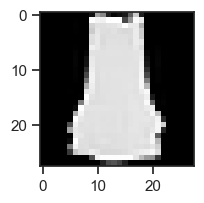

True label: Dress
Predicted label: Dress


In [15]:
# datasetからサンプルを一つ取り出す
image, label = random.choice(dataset_test)

# 学習済みモデルを使ってラベルを推論
# 下記コードでは，畳み込みニューラルネットワークの出力値が最も高いラベルを取得している
label_predicted = torch.argmax(model(image.to(device).reshape(-1, 1, 28, 28)))

fig, ax = plt.subplots()
ax.imshow(image.reshape(28, 28), cmap="gray")
fig.set_size_inches(2, 2)
plt.show()
print("True label:", id2label[label])
print("Predicted label:", id2label[int(label_predicted)])

何回か推論を行ってみよう．大体当たっている？

---
## 例題2: 勾配法

最後に，機械学習の基礎となる技術「勾配法」を体験してみよう．
ニューラルネットワークの損失関数は複雑なので，それを対象として勾配法が関数の微分最小化をどのように行うかを体感するのは難しいかもしれない．
そこで，この例題では人工的に生成した2次元データを用いて，勾配法による2次関数の最小化問題を体験する．

まずは以下のコードを実行して，例題で用いるデータを読み込もう．

In [16]:
# 表データを扱うライブラリ
import pandas as pd

# データを読み込む
data_url = "https://raw.githubusercontent.com/hontolab-courses/dmml-2023/main/dataset/sgd-data.tsv"
df = pd.read_table(data_url, header=0, sep="\t")

# 末尾10件のデータを表示
df.tail()

,x,y
995,-0.282698,-3.453855
996,0.332550,-0.592492
997,1.551304,2.760538
998,1.923891,6.482983
999,-0.105533,-0.388455


このデータセットには，上記のような2次元のデータが1000個収められている．
以下のコードを実行して，データの分布を確認してみよう．

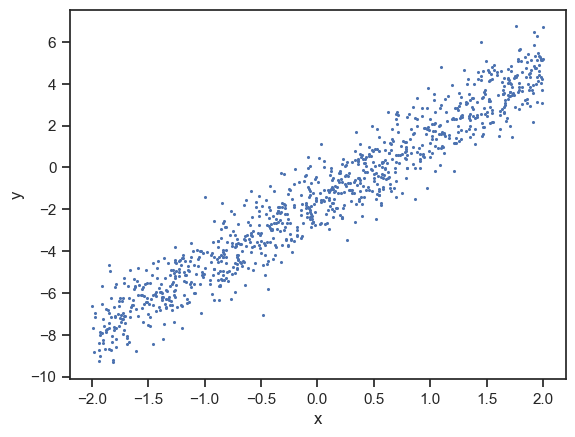

In [17]:
# 可視化
sns.scatterplot(x=df["x"], y=df["y"], linewidth=0, s=5)
plt.show()

散布図を見る限り，データは直線的に分布しているようである．
そこで，「このデータセットは直線
$$
\begin{align}
y=&f(x)\\
　=&wx - 1.59
\end{align}
$$

に従って発生したもの」と仮定し，直線のパラメータ$w$（傾き）を勾配法を用いて推定することにしよう（なぜ切片が-1.59かというと，データ作成者である山本はこの直線が何かを知っている…）．

さて，直線のパラメータはどのように求めるか．わたしたちはこの直線に従って発生したと思われるデータ集合$D=\{(x_1, y_1),...,(x_{1000}, y_{1000})\}$を持っている．
ここでは，予想される直線（$y=f(x)$）から推測される$y$と実際の$y$の値の2乗誤差の総和を損失関数と見なし，その損失関数を最小化するパラメータ$w$を見つける戦略を採る（いわゆる[最小二乗法](https://ja.wikipedia.org/wiki/最小二乗法)）．つまり，以下の関数$L$を最小化するパラメータ$w$を見つけることにする（$L$は$w$に関する2次関数）．

$$
\begin{align}
L=& \sum_{i=1}^{1000}(y_i - f(x_i))^2 \\
 =& \sum_{i=1}^{1000}(y_i - wx_i + 1.59)^2
\end{align}
$$

計算機で関数を微分最小化するには，勾配法を用いるのが定番である．
今回は勾配法の中でも**最急降下法**を用いる．
関数$L(w)$を最急降下法で微分最小化するには，適当な$w^{(0)}$からスタートして，

$$
\begin{align}
w^{(k+1)} = w^{(k)} - \alpha \frac{dL}{dw}
\end{align}
$$

のルールを繰り返し適応しながら$w$を更新していく．
ここで関数$L(w)$の$w$に関する導関数（勾配）は

$$
\begin{align}
\frac{dL}{dw} =& \sum_{i=1}^{1000}2(-x_i)(y_i - wx_i + 1.59)
\end{align}
$$

となるので，パラメータ$w$の更新式は
$$
\begin{align}
w^{k+1} = w^{k} - \alpha \sum_{i=1}^{1000}2x_i(wx_i - 1.59 - y_i)
\end{align}
$$
となる．

ということで，この更新式を使って最急降下法による関数の微分最小化および最適なパラメータの推定を行ってみよう．
最急降下法ではパラメータの更新の細かさを決める学習率$\alpha$を設定する必要がある．
今回は$\alpha=10^{-4}$としよう．
また，パラメータ更新の終了条件は，
* パラメータ$w$の更新回数が10000回になったとき
* パラメータ$w$の更新量の絶対値が$10^{-8}$未満になったとき（つまりパラメータがほとんど変化しなくなったとき）

としよう．

前置きが長くなったが，以上のことを踏まえて，コードを書く．
まずは，関数$L(w)$の$w$に関する勾配をコードで定義する．

In [18]:
def gradient(x_list, y_list, w):
    grad = 0
    
    # データを1個ずつ処理
    for x, y in zip(x_list, y_list):
        grad += 2 * x * (w * x  - 1.59 - y)
        
    return grad

勾配の式が定義できたので，最急降下法のコードを実装する．

In [19]:
def gradient_descent(x_list, y_list, alpha=0.0001, delta_threshold=1e-8, epoch_num=10000):
    """ alpha: 学習率，
        delta_treshold: パラメータの更新量の絶対値に対する閾値
        epoch_num: 更新回数の上限
    """
    
    # パラメータをランダムに初期化
    w = random.random()
    
    for epoch in range(epoch_num):
        # パラメータの更新式
        w_new = w - alpha * gradient(x_list, y_list, w)

        # パラメータの更新量の絶対値
        w_delta = abs(w_new - w)
        if w_delta < delta_threshold:
            # パラメータがほぼ変化しなくなったら
            return w_new
        else:
            # まだ変化する余地があるなら，引き続きパラメータを更新する
            if epoch % 5 == 0:
                print(f"更新回数 {epoch}回目\t", w)
            w = w_new
            
    return w_new

準備が整ったので，以下のコードを走らせて最急降下法を実行してみよう．

In [20]:
# データセット
x_list = df["x"]
y_list = df["y"]

# 最急降下法の実行
w = gradient_descent(x_list, y_list, 0.0001, 1e-8, 10000)

print("\nOptimized w =", w)

更新回数 0回目	 0.5874993370344522
更新回数 5回目	 2.5761995079979485
更新回数 10回目	 3.0280053942614744
更新回数 15回目	 3.1306496047074726
更新回数 20回目	 3.1539689864561584
更新回数 25回目	 3.159266835821243
更新回数 30回目	 3.1604704358222033
更新回数 35回目	 3.1607438775270325
更新回数 40回目	 3.160805999798451
更新回数 45回目	 3.1608201131415807
更新回数 50回目	 3.1608233195029993
更新回数 55回目	 3.160824047945116
更新回数 60回目	 3.160824213437351

Optimized w = 3.160824235194694


$w$の値として，3.14付近の値が推定されたのではないだろうか．
実は今回用いたデータセットは，$y=3.14x-1.59$という直線から発生させたものであった．
直線の傾きは3.14なので，推定されたパラメータ$w$はおおよそ当たっていたことになる．